In [1]:
import pandas as pd
import numpy as np


In [2]:
# for managing class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler

In [3]:
# for plotting 
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [4]:
# define parameters
interval= True
WS_level=0.8
make_gridsearch=True
make_kfold=True
K_folds=5

In [5]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import pickle
import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [6]:
# create folder to save models
models_loc='models4wells_2d_1/'
if not os.path.exists(models_loc):
    os.makedirs(models_loc)

In [7]:
# read data
logs_df = pd.read_csv("Data/logs_4wells.csv")
seismic_df=pd.read_csv('data/seismic_4wells.csv')
section_stack_df=pd.read_csv('data/section_2D_1.csv')
stack_section2=pd.read_csv('data/section_2D_2.csv')

## Creating Sweetness Attribute

In [8]:
sqrInsF = section_stack_df['InstF'] *section_stack_df['InstF']
sqrInsF
InF = np.sqrt(sqrInsF)
sqrtInsF = np.sqrt(InF)

sweetness = section_stack_df['AmpEnv']/sqrtInsF
sweetness
section_stack_df['Sweetness'] = sweetness
section_stack_df.loc[section_stack_df['InstF'] <0,'Sweetness'] = section_stack_df.loc[section_stack_df['InstF'] <0,'Sweetness'] * -1 
section_stack_df
seismic_df
sqrInsF = seismic_df['InstF'] *seismic_df['InstF']
sqrInsF
InF = np.sqrt(sqrInsF)
sqrtInsF = np.sqrt(InF)
sweetness = seismic_df['AmpEnv']/sqrtInsF
seismic_df['Sweetness'] = sweetness
seismic_df.loc[seismic_df['InstF'] <0,'Sweetness'] = seismic_df.loc[seismic_df['InstF'] <0,'Sweetness'] * -1 
seismic_df

section_stack_df

,Time,DomF,Trace,AppPolr,Seismic,Der,QuadrTrace,SecDerInstAmpl,Integrated,AmpEnv,P_wave,Density,AWF,SecDer,AWCP,InstF,Horison,Imp,Sweetness
0,0.0,2.44141,1.0,0.000000,0.000000,0.000000,0.006623,0.000092,0.039672,0.006610,1479.19,1.20252,0.001842,0.000000,0.001842,6.65428,2D-wb,1778.755559,0.002562
1,4.0,2.44141,1.0,0.000000,0.000000,0.000000,0.006311,0.000092,0.051413,0.006219,1479.19,1.20252,0.001833,0.000000,0.001833,-7.25468,2D-wb,1778.755559,-0.002309
2,8.0,2.44141,1.0,0.000000,0.000000,0.000000,0.007313,0.000092,0.063827,0.007301,1479.19,1.20252,0.001856,0.000000,0.001856,6.34233,2D-wb,1778.755559,0.002899
3,12.0,2.44141,1.0,0.000000,0.000000,0.000000,0.007022,-0.000091,0.076711,0.006932,1479.19,1.20252,0.001849,0.000000,0.001849,-6.86129,2D-wb,1778.755559,-0.002646
4,16.0,2.44141,1.0,0.000000,0.000000,0.000000,0.008134,0.000097,0.089974,0.008122,1479.19,1.20252,0.001867,0.000000,0.001867,6.01937,2D-wb,1778.755559,0.003310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993289,4984.0,11.22920,794.0,0.417634,0.330542,-0.092427,0.176002,-0.000378,1.420740,0.417634,4865.46,2.69136,0.331198,-0.027118,0.331198,10.87850,bottom,13094.704426,0.126623
993290,4988.0,11.23050,794.0,0.357775,0.250767,-0.079775,0.120611,-0.001149,1.680460,0.357775,4879.07,2.69136,0.215173,0.012652,0.215173,10.12870,bottom,13131.333835,0.112417
993291,4992.0,11.23050,794.0,0.292691,0.236846,-0.013921,0.123388,-0.000327,1.949060,0.292691,4892.68,2.69136,0.119895,0.065853,0.119895,8.27151,bottom,13167.963245,0.101769
993292,4996.0,11.23050,794.0,0.237282,0.308537,0.071692,0.036278,0.000605,2.312900,0.237282,4906.29,2.68547,0.046884,0.085613,0.046884,9.53726,bottom,13175.694606,0.076834


In [9]:
section_stack_df.columns.tolist()

['Time',
 'DomF',
 'Trace',
 'AppPolr',
 'Seismic',
 'Der',
 'QuadrTrace',
 'SecDerInstAmpl',
 'Integrated',
 'AmpEnv',
 'P_wave',
 'Density',
 'AWF',
 'SecDer',
 'AWCP',
 'InstF',
 'Horison',
 'Imp',
 'Sweetness']

In [10]:
logs_df.isna().sum()

Time                0
Density             0
P_wave              0
Porosity            0
V_clay              0
Water Saturation    0
log_ID              0
Horison             0
Imp                 0
dtype: int64

In [11]:
logs_df

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,log_ID,Horison,Imp
0,514.8757,1.2545,1577.8733,0.0557,0.4820,1.0,6507_2-1,2D-mid,1979.442055
1,515.0686,1.2542,1579.8525,0.0550,0.4766,1.0,6507_2-1,2D-mid,1981.451006
2,515.2613,1.2724,1581.8326,0.0579,0.5014,1.0,6507_2-1,2D-mid,2012.723800
3,515.4538,1.2821,1583.8119,0.0592,0.5126,1.0,6507_2-1,2D-mid,2030.605237
4,515.6460,1.2897,1585.7920,0.0601,0.5201,1.0,6507_2-1,2D-mid,2045.195942
...,...,...,...,...,...,...,...,...,...
74748,2788.0627,2.5312,2730.6299,0.1232,0.7761,1.0,6507_3-9S,2D-K65,6911.770403
74749,2788.1743,2.4875,2727.8901,0.1487,0.7458,1.0,6507_3-9S,2D-K65,6785.626624
74750,2788.2861,2.4531,2725.1487,0.1668,0.7255,1.0,6507_3-9S,2D-K65,6685.062276
74751,2788.3979,2.4308,2722.4080,0.1769,0.7027,1.0,6507_3-9S,2D-K65,6617.629366


In [12]:
logs_df = logs_df[(logs_df['Time']>=1050) & (logs_df['Time']<=2850)].reset_index(drop=True)
logs_df = logs_df[(logs_df['Time']>=1050) & (logs_df['Time']<=3200)].reset_index(drop=True)



'''logs_df =logs_df[(logs_df['log_ID']=='6507_3-9s') & (logs_df['Time']>=2650) & (logs_df['Time']<=2800)].append(
        logs_df[(logs_df['log_ID']=='6507_2-4') & (logs_df['Time']>=2670) & (logs_df['Time']<=2800)]).append(
        logs_df[(logs_df['log_ID']=='6507_2-2') & (logs_df['Time']>=2666) & (logs_df['Time']<=2800)]).append(
        logs_df[(logs_df['log_ID']=='6507_2-1') & (logs_df['Time']>=2674) & (logs_df['Time']<=2840)]).reset_index(drop=True) '''


"logs_df =logs_df[(logs_df['log_ID']=='6507_3-9s') & (logs_df['Time']>=2650) & (logs_df['Time']<=2800)].append(\n        logs_df[(logs_df['log_ID']=='6507_2-4') & (logs_df['Time']>=2670) & (logs_df['Time']<=2800)]).append(\n        logs_df[(logs_df['log_ID']=='6507_2-2') & (logs_df['Time']>=2666) & (logs_df['Time']<=2800)]).append(\n        logs_df[(logs_df['log_ID']=='6507_2-1') & (logs_df['Time']>=2674) & (logs_df['Time']<=2840)]).reset_index(drop=True) "

In [13]:
#logs_df.groupby(['log_ID','Time']).mean()

In [14]:
#logs_df.loc[10:20]
logs_df

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,log_ID,Horison,Imp
0,1050.0450,2.0322,2190.8054,0.0776,0.6714,1.0,6507_2-1,2D-mid,4452.154734
1,1050.1869,2.0291,2181.9836,0.0783,0.6776,1.0,6507_2-1,2D-mid,4427.462923
2,1050.3293,2.0260,2173.2310,0.0790,0.6839,1.0,6507_2-1,2D-mid,4402.966006
3,1050.4731,2.0009,2151.1841,0.0776,0.6716,1.0,6507_2-1,2D-mid,4304.304266
4,1050.6184,1.9758,2129.5786,0.0762,0.6593,1.0,6507_2-1,2D-mid,4207.621398
...,...,...,...,...,...,...,...,...,...
48770,2788.0627,2.5312,2730.6299,0.1232,0.7761,1.0,6507_3-9S,2D-K65,6911.770403
48771,2788.1743,2.4875,2727.8901,0.1487,0.7458,1.0,6507_3-9S,2D-K65,6785.626624
48772,2788.2861,2.4531,2725.1487,0.1668,0.7255,1.0,6507_3-9S,2D-K65,6685.062276
48773,2788.3979,2.4308,2722.4080,0.1769,0.7027,1.0,6507_3-9S,2D-K65,6617.629366


In [15]:
#sb.pairplot(logs_df, diag_kind="kde")
#fig, ax = plt.subplots()


# # Opposite Moving Average

In [16]:
features = seismic_df.columns.to_list()
features.remove('log_ID')
features
def opposite_mov_avg(data):
    
    data_1=(data+data.shift(1))/2
    data_1=data.append(data_1.dropna()).sort_values('Time').reset_index(drop=True)
    data_2=(data_1+data_1.shift(1))/2
    data_2=data_1.append(data_2.dropna()).sort_values('Time').reset_index(drop=True)
    return data_2
seismic_df_extra_points=opposite_mov_avg(seismic_df[seismic_df['log_ID']=='6507_2-1'][features])
seismic_df_extra_points

,Time,Seismic,QuadrTrace,SecDerInstAmpl,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
0,0.0,-7.548390e-08,0.002513,0.000018,-5.314120e-07,-0.000959,-2.516130e-08,0.008822,20.0195,5.453330,0.000000,0.001618,-1.617760e-03,0.000693
1,1.0,-8.177418e-08,0.002471,0.000018,-5.588895e-07,-0.000951,-2.516130e-08,0.004422,20.0195,2.603595,0.000000,0.001582,-1.213345e-03,0.000368
2,2.0,-8.806445e-08,0.002428,0.000018,-5.863670e-07,-0.000943,-2.516130e-08,0.000022,20.0195,-0.246140,0.000000,0.001547,-8.089303e-04,0.000044
3,3.0,-9.435473e-08,0.002386,0.000018,-6.138445e-07,-0.000935,-2.516130e-08,-0.004377,20.0195,-3.095875,0.000000,0.001512,-4.045155e-04,-0.000281
4,4.0,-1.006450e-07,0.002343,0.000018,-6.413220e-07,-0.000927,-2.516130e-08,-0.008777,20.0195,-5.945610,0.000000,0.001476,-1.006450e-07,-0.000605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,3696.0,6.878200e-01,0.099278,0.006486,1.406940e-01,0.100497,-6.171700e-02,3.223610,24.4141,28.761200,-0.539050,0.112082,-1.120820e-01,0.020899
3697,3697.0,5.898730e-01,0.167429,0.007825,2.535495e-01,0.075077,-1.442345e-01,2.288616,24.4141,9.070900,-0.486805,0.086643,-8.664332e-02,0.015309
3698,3698.0,4.919260e-01,0.235581,0.009164,3.664050e-01,0.049657,-2.267520e-01,1.353623,24.4141,-10.619400,-0.434560,0.061205,-6.120465e-02,0.009719
3699,3699.0,3.939790e-01,0.303733,0.010503,4.792605e-01,0.024237,-3.092695e-01,0.418629,24.4141,-30.309700,-0.382315,0.035766,-3.576597e-02,0.004129


In [17]:
count=0
#features = seismic_df.columns.to_list()
seismic_df_extra_points=[]
for log_id in seismic_df['log_ID'].value_counts().index.to_list():
    
    df_extra_points=opposite_mov_avg(seismic_df[seismic_df['log_ID']==log_id][features])
    df_extra_points['log_ID']=log_id
    
    if count==0:
        seismic_df_extra_points=df_extra_points
    else:
        seismic_df_extra_points=seismic_df_extra_points.append(df_extra_points)
    
    count=count+1

In [18]:

seismic_df_extra_points

,Time,Seismic,QuadrTrace,SecDerInstAmpl,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,log_ID
0,0.0,-7.548390e-08,0.002513,0.000018,-5.314120e-07,-0.000959,-2.516130e-08,0.008822,20.0195,5.453330,0.000000,0.001618,-1.617760e-03,0.000693,6507_2-1
1,1.0,-8.177418e-08,0.002471,0.000018,-5.588895e-07,-0.000951,-2.516130e-08,0.004422,20.0195,2.603595,0.000000,0.001582,-1.213345e-03,0.000368,6507_2-1
2,2.0,-8.806445e-08,0.002428,0.000018,-5.863670e-07,-0.000943,-2.516130e-08,0.000022,20.0195,-0.246140,0.000000,0.001547,-8.089303e-04,0.000044,6507_2-1
3,3.0,-9.435473e-08,0.002386,0.000018,-6.138445e-07,-0.000935,-2.516130e-08,-0.004377,20.0195,-3.095875,0.000000,0.001512,-4.045155e-04,-0.000281,6507_2-1
4,4.0,-1.006450e-07,0.002343,0.000018,-6.413220e-07,-0.000927,-2.516130e-08,-0.008777,20.0195,-5.945610,0.000000,0.001476,-1.006450e-07,-0.000605,6507_2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2796,2796.0,2.021190e-01,-0.519607,0.002647,-1.905970e+00,0.030192,2.949970e-01,-0.049926,29.2969,-0.189041,-0.091461,0.264099,-2.640990e-01,-0.607420,6507_3-9S
2797,2797.0,2.409712e-01,-0.410583,0.004051,-1.807952e+00,0.022794,2.601000e-01,-0.206187,29.2969,-1.087418,-0.103493,0.242685,-2.426850e-01,-0.478502,6507_3-9S
2798,2798.0,2.798235e-01,-0.301558,0.005456,-1.709935e+00,0.015396,2.252030e-01,-0.362447,29.2969,-1.985796,-0.115524,0.221271,-2.212710e-01,-0.349585,6507_3-9S
2799,2799.0,3.186758e-01,-0.192534,0.006860,-1.611918e+00,0.007998,1.903060e-01,-0.518708,29.2969,-2.884173,-0.127556,0.199857,-1.998570e-01,-0.220668,6507_3-9S


## Opposite Moving Average and Moving Average Implementation

In [19]:
opposite_mov_avg=True
if opposite_mov_avg==True:
    logs_df['Time_rounded']=np.round(logs_df['Time']/1)*1
    horison_vect = logs_df.groupby(['log_ID','Time_rounded'])['Horison'].first().values
    logs_df=logs_df.groupby(['log_ID','Time_rounded']).mean().reset_index().drop('Time', axis=1).rename(columns={'Time_rounded': 'Time'})
    logs_df['Horison'] = horison_vect
    
    log_seismic_df=pd.merge(logs_df,seismic_df_extra_points, how='inner', on=['log_ID','Time']).sort_values(['log_ID','Time'])
    #log_seismic_df = pd.merge(l,seismic_df_extra_points,on=['log_ID','Time'])

# Implements moving average for the merge
else:
    logs_av = logs_df
    logs_av['Time_rounded'] = np.round(logs_av['Time']/4)*4
    horison_vect = logs_av.groupby(['log_ID','Time_rounded'])['Horison'].first().values
    logs_av = logs_av.groupby(['log_ID','Time_rounded']).mean()
    logs_av['Horison'] = horison_vect
    logs_av.reset_index(inplace=True)
    logs_av.drop('Time',axis=1, inplace=True)
    logs_av = logs_av.rename(columns={'Time_rounded':'Time'})
    # Combining the logs_avg and seismic dataframes picking only unique values of time and log_id present in the two dataframes
    log_seismic_df = pd.merge(logs_av,seismic_df,on=['log_ID','Time'])
    


In [20]:
seismic_df.isna().sum()

Time              0
Seismic           0
log_ID            0
QuadrTrace        0
SecDerInstAmpl    0
Integrated        0
AWCP              0
Der               0
AWF               0
DomF              0
InstF             0
SecDer            0
AmpEnv            0
AppPolr           0
Sweetness         0
dtype: int64

In [21]:
log_id_list = logs_df['log_ID'].value_counts().index.tolist()

In [22]:
log_seismic_df

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
0,6507_2-1,1050.0,2.022050,2174.301025,0.078125,0.676125,1.0,4396.721982,2D-mid,0.790786,...,1.148103,0.790004,-0.736841,35.832850,27.391900,24.977900,-0.443506,1.438730,-1.438730,0.288394
1,6507_2-1,1051.0,2.019371,2159.662000,0.079857,0.691171,1.0,4362.258944,2D-mid,0.570945,...,1.244882,0.570002,-0.808105,34.728425,27.403050,25.366950,-0.364282,1.372105,-1.372105,0.272815
2,6507_2-1,1052.0,2.038714,2169.162357,0.082043,0.710286,1.0,4422.704428,2D-mid,0.351103,...,1.341660,0.349999,-0.879370,33.624000,27.414200,25.756000,-0.285058,1.305480,-1.305480,0.257236
3,6507_2-1,1053.0,2.016857,2153.268071,0.081343,0.694886,1.0,4343.038179,2D-mid,0.161439,...,1.244762,0.160359,-0.849192,32.518200,27.424575,26.301525,-0.183615,1.240407,-1.240407,0.242362
4,6507_2-1,1054.0,2.042300,2169.435500,0.082629,0.715386,1.0,4430.589106,2D-mid,-0.028225,...,1.147865,-0.029281,-0.819014,31.412400,27.434950,26.847050,-0.082172,1.175335,-1.175335,0.227488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6481,6507_3-9S,2785.0,2.444589,2770.978400,0.171311,0.702289,1.0,6774.149472,2D-K65,-0.740819,...,-1.566780,-0.723083,0.206942,18.410325,29.296900,21.131200,0.238434,0.872389,-0.872389,0.189919
6482,6507_3-9S,2786.0,2.456433,2782.700444,0.163833,0.701522,1.0,6835.567728,2D-K65,-0.653658,...,-1.695630,-0.618295,0.254176,17.640350,29.296900,21.318000,0.221935,0.829006,-0.829006,0.179735
6483,6507_3-9S,2787.0,2.448500,2758.036467,0.167800,0.715378,1.0,6753.148538,2D-K65,-0.566497,...,-1.824480,-0.513508,0.301410,16.870375,29.296900,21.504800,0.205435,0.785624,-0.785624,0.169551
6484,6507_3-9S,2788.0,2.460022,2733.370856,0.161667,0.733333,1.0,6724.053214,2D-K65,-0.479336,...,-1.953330,-0.408720,0.348644,16.100400,29.296900,21.691600,0.188936,0.742242,-0.742242,0.159367


In [23]:
log_id_list

['6507_2-1', '6507_2-4', '6507_3-9S', '6507_2-2']

In [24]:
def plot_per_log(df, column_name, type_p='-',color=['blue','blue','blue','blue']):
    # plot Time vs Paramater for each well on separate subgraph
    log_ID_list=df['log_ID'].value_counts().index.tolist()
    fig, ax = plt.subplots(1,len(log_ID_list),figsize=(15,10))
    
    for i in list(range(len(log_ID_list))):
        ax[i].plot(df[df['log_ID']==log_ID_list[i]][column_name], -df[df['log_ID']==log_ID_list[i]]['Time'],type_p, color=color[i])
        ax[i].set_xlabel(column_name)
        ax[i].set_title(log_ID_list[i])
        
    ax[0].set_ylabel('Time')

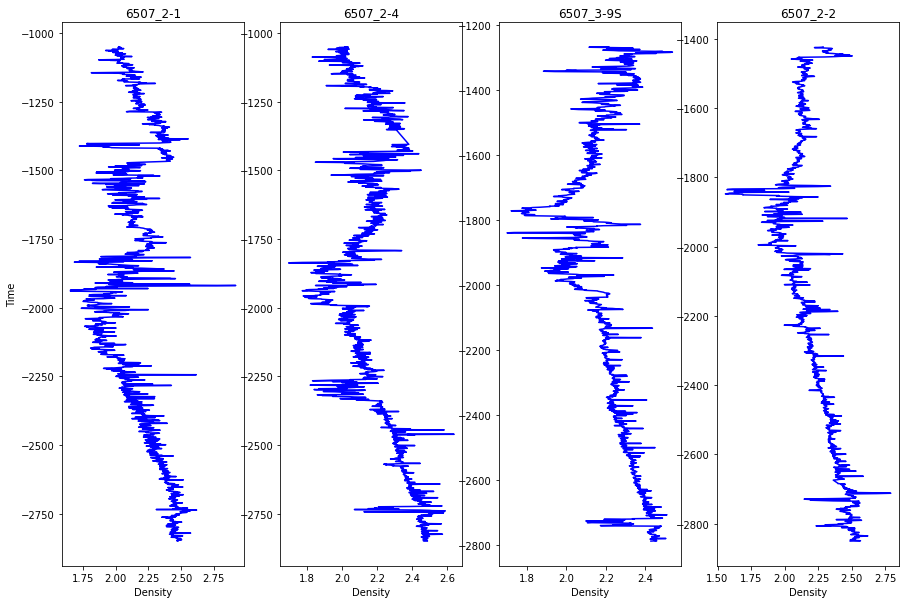

In [25]:
plot_per_log(logs_df,'Density')


In [26]:
# Plotting Time vs density for each well on separate subgraphs
column_name = 'Density'


In [27]:
if opposite_mov_avg==False:
    column_name = 'Density'
    fig,ax = plt.subplots(1,len(log_id_list),figsize=(15,10)) # lenght of log_id_list is 4 so we say plot 1 row and 4 columns

    for  i in list(range(len(log_id_list))):
        # ploting only for distinct well matched by log_id and grabbing data from a particular column in this case Density
        ax[i].plot(logs_df[logs_df['log_ID']==log_id_list[i]][column_name], logs_df[logs_df['log_ID']==log_id_list[i]]['Time'])
        ax[i].plot(logs_av[logs_av['log_ID']==log_id_list[i]][column_name], logs_av[logs_av['log_ID']==log_id_list[i]]['Time'])
        ax[i].set_xlabel(column_name)
        ax[i].set_title(log_id_list[i])
    ax[0].set_ylabel('Time')

In [28]:
log_id_list

['6507_2-1', '6507_2-4', '6507_3-9S', '6507_2-2']

In [29]:
# Checking for intervals with low water saturation from log data
#logs_av[(logs_av['Water Saturation'] <= 0.6)]
#l_av[(l_av['Water Saturation'] <= 0.9)]
log_seismic_df[(log_seismic_df['Water Saturation'] <= 0.9)]

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
3052,6507_2-2,2683.0,2.395200,2633.997575,0.272725,0.326125,0.712050,6308.950992,2D-mid2,-0.252281,...,-3.610008,-0.261815,0.816174,36.586350,24.913750,20.751425,0.325814,1.763012,-1.763012,0.387030
3097,6507_2-2,2728.0,2.242009,2746.989345,0.238936,0.089818,0.579636,6165.177518,2D-K65,-1.417350,...,-2.075750,-1.422450,0.628147,57.165200,25.149500,28.490900,0.989837,2.006440,-2.006440,0.375901
3098,6507_2-2,2729.0,2.144422,2503.530378,0.283556,0.037811,0.428556,5368.958138,2D-K65,-1.090822,...,-2.108678,-1.097195,0.797640,56.507075,25.148625,28.645375,0.911871,1.973183,-1.973183,0.368734
3099,6507_2-2,2730.0,2.187913,2531.556863,0.274562,0.170425,0.602338,5549.203059,2D-K65,-0.764294,...,-2.141605,-0.771939,0.967133,55.848950,25.147750,28.799850,0.833904,1.939925,-1.939925,0.361567
3101,6507_2-2,2732.0,2.190743,2658.416643,0.267643,0.059057,0.608000,5824.909777,2D-K65,-0.111237,...,-2.207460,-0.121428,1.306120,54.532700,25.146000,29.108800,0.677971,1.873410,-1.873410,0.347233
3102,6507_2-2,2733.0,2.272957,2721.037671,0.237157,0.144386,0.871114,6188.210008,2D-K65,0.183530,...,-1.947005,0.174324,1.274355,53.492975,25.144125,29.228425,0.476715,1.830695,-1.830695,0.338675
3157,6507_2-2,2788.0,2.383164,3014.814855,0.187182,0.399500,0.897582,7184.116138,2D-K65,-0.538534,...,0.610690,-0.546841,-0.893710,36.466100,24.677700,29.034400,-0.267116,1.255960,-1.255960,0.233088
3175,6507_2-2,2806.0,2.232862,2776.343375,0.275200,0.412750,0.824662,6193.653547,2D-K65,0.182862,...,-2.898200,0.173497,0.745706,30.246200,24.360550,21.312150,0.146326,1.418475,-1.418475,0.307295
4842,6507_2-4,2724.0,2.385590,3313.550820,0.184170,0.335820,0.832720,7907.320329,2D-mid2,-1.012620,...,-1.321540,-1.014810,0.370982,-177.758000,24.935900,24.208500,0.578495,1.208050,-1.208050,0.245528
4843,6507_2-4,2725.0,2.208689,3068.556900,0.261322,0.122178,0.339367,6784.674696,2D-mid2,-0.855753,...,-1.429347,-0.858969,0.435105,-161.687750,24.916300,24.092075,0.497994,1.157258,-1.157258,0.235703


In [30]:
log_seismic_df.columns

Index(['log_ID', 'Time', 'Density', 'P_wave', 'Porosity', 'V_clay',
       'Water Saturation', 'Imp', 'Horison', 'Seismic', 'QuadrTrace',
       'SecDerInstAmpl', 'Integrated', 'AWCP', 'Der', 'AWF', 'DomF', 'InstF',
       'SecDer', 'AmpEnv', 'AppPolr', 'Sweetness'],
      dtype='object')

In [31]:
log_seismic_df['log_ID'].value_counts()
#log_seismic_df.isna().sum

6507_2-1     1801
6507_2-4     1749
6507_3-9S    1517
6507_2-2     1419
Name: log_ID, dtype: int64

Columns to use
Columns that exist in both 2d seismic and data for wells.

In [32]:
features = log_seismic_df.columns.intersection(section_stack_df.columns).to_list()
features
# features = ['Density', 'P_wave','Imp' ,'Porosity', 'V_clay'] #FOR 3D SECTION AND 2D SECTION WITH WELLS ABSENT
features = ['Density', 'P_wave','Imp','Sweetness','AmpEnv','Seismic',]


In [33]:
# Using Pearson Correlation 
#cor = log_seismic_df.corr()
#fig, ax = plt.subplots(figsize=(15,10))
#sb.heatmap(cor, annot=True, cmap=plt.cm.Greens,ax=ax)

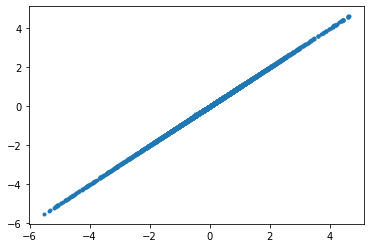

In [34]:
# Removing AWCP because of high corellation with seismic
plt.plot(log_seismic_df['Seismic'],log_seismic_df['AWCP'],'.')
# Removing AWCP
#features.remove('AWCP')


We now split the data into train and validation set
The target is Water Saturation and only horizons 2D-K65,2D-BCU, 2D-bottom

In [35]:
log_seismic_df

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
0,6507_2-1,1050.0,2.022050,2174.301025,0.078125,0.676125,1.0,4396.721982,2D-mid,0.790786,...,1.148103,0.790004,-0.736841,35.832850,27.391900,24.977900,-0.443506,1.438730,-1.438730,0.288394
1,6507_2-1,1051.0,2.019371,2159.662000,0.079857,0.691171,1.0,4362.258944,2D-mid,0.570945,...,1.244882,0.570002,-0.808105,34.728425,27.403050,25.366950,-0.364282,1.372105,-1.372105,0.272815
2,6507_2-1,1052.0,2.038714,2169.162357,0.082043,0.710286,1.0,4422.704428,2D-mid,0.351103,...,1.341660,0.349999,-0.879370,33.624000,27.414200,25.756000,-0.285058,1.305480,-1.305480,0.257236
3,6507_2-1,1053.0,2.016857,2153.268071,0.081343,0.694886,1.0,4343.038179,2D-mid,0.161439,...,1.244762,0.160359,-0.849192,32.518200,27.424575,26.301525,-0.183615,1.240407,-1.240407,0.242362
4,6507_2-1,1054.0,2.042300,2169.435500,0.082629,0.715386,1.0,4430.589106,2D-mid,-0.028225,...,1.147865,-0.029281,-0.819014,31.412400,27.434950,26.847050,-0.082172,1.175335,-1.175335,0.227488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6481,6507_3-9S,2785.0,2.444589,2770.978400,0.171311,0.702289,1.0,6774.149472,2D-K65,-0.740819,...,-1.566780,-0.723083,0.206942,18.410325,29.296900,21.131200,0.238434,0.872389,-0.872389,0.189919
6482,6507_3-9S,2786.0,2.456433,2782.700444,0.163833,0.701522,1.0,6835.567728,2D-K65,-0.653658,...,-1.695630,-0.618295,0.254176,17.640350,29.296900,21.318000,0.221935,0.829006,-0.829006,0.179735
6483,6507_3-9S,2787.0,2.448500,2758.036467,0.167800,0.715378,1.0,6753.148538,2D-K65,-0.566497,...,-1.824480,-0.513508,0.301410,16.870375,29.296900,21.504800,0.205435,0.785624,-0.785624,0.169551
6484,6507_3-9S,2788.0,2.460022,2733.370856,0.161667,0.733333,1.0,6724.053214,2D-K65,-0.479336,...,-1.953330,-0.408720,0.348644,16.100400,29.296900,21.691600,0.188936,0.742242,-0.742242,0.159367


In [36]:
df = log_seismic_df[(log_seismic_df['Horison']=='2D-K65')|(log_seismic_df['Horison']=='2D-BCU')|(log_seismic_df['Horison']=='2D-mid2')]
#df =log_seismic_df

In [37]:
df['Horison'].value_counts()

2D-mid2    3625
2D-K65      375
Name: Horison, dtype: int64

In [38]:
# defining test, target, features
test_well_name = '6507_2-4'
target_val=0.9

In [39]:
df['target'] = 0
df

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,target
782,6507_2-1,1832.0,2.061643,2311.373543,0.238586,0.579757,1.0,4771.819793,2D-mid2,-2.394490,...,-2.395250,1.066240,82.797700,20.13880,20.822600,1.158980,3.976340,3.976340,0.871397,0
783,6507_2-1,1833.0,1.969329,2117.775714,0.181829,0.672143,1.0,4179.877024,2D-mid2,-1.930504,...,-1.931366,1.263665,83.066450,20.15205,20.680325,1.066661,4.017543,4.017543,0.883592,0
784,6507_2-1,1834.0,1.681433,1827.022333,0.202017,0.652933,1.0,3072.645899,2D-mid2,-1.466517,...,-1.467483,1.461090,83.335200,20.16530,20.538050,0.974342,4.058745,4.058745,0.895786,0
785,6507_2-1,1835.0,1.860083,1990.464817,0.183967,0.670650,1.0,3702.871109,2D-mid2,-1.002531,...,-1.003599,1.658515,83.603950,20.17855,20.395775,0.882023,4.099947,4.099947,0.907981,0
786,6507_2-1,1836.0,1.859500,2002.424043,0.203629,0.651300,1.0,3723.785889,2D-mid2,-0.538545,...,-0.539715,1.855940,83.872700,20.19180,20.253500,0.789704,4.141150,4.141150,0.920176,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6481,6507_3-9S,2785.0,2.444589,2770.978400,0.171311,0.702289,1.0,6774.149472,2D-K65,-0.740819,...,-0.723083,0.206942,18.410325,29.29690,21.131200,0.238434,0.872389,-0.872389,0.189919,0
6482,6507_3-9S,2786.0,2.456433,2782.700444,0.163833,0.701522,1.0,6835.567728,2D-K65,-0.653658,...,-0.618295,0.254176,17.640350,29.29690,21.318000,0.221935,0.829006,-0.829006,0.179735,0
6483,6507_3-9S,2787.0,2.448500,2758.036467,0.167800,0.715378,1.0,6753.148538,2D-K65,-0.566497,...,-0.513508,0.301410,16.870375,29.29690,21.504800,0.205435,0.785624,-0.785624,0.169551,0
6484,6507_3-9S,2788.0,2.460022,2733.370856,0.161667,0.733333,1.0,6724.053214,2D-K65,-0.479336,...,-0.408720,0.348644,16.100400,29.29690,21.691600,0.188936,0.742242,-0.742242,0.159367,0


In [40]:
df.loc[df['Water Saturation'] <= target_val,'target']= 1

In [41]:
df[df['target']==1]

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,target
3052,6507_2-2,2683.0,2.395200,2633.997575,0.272725,0.326125,0.712050,6308.950992,2D-mid2,-0.252281,...,-0.261815,0.816174,36.586350,24.913750,20.751425,0.325814,1.763012,-1.763012,0.387030,1
3097,6507_2-2,2728.0,2.242009,2746.989345,0.238936,0.089818,0.579636,6165.177518,2D-K65,-1.417350,...,-1.422450,0.628147,57.165200,25.149500,28.490900,0.989837,2.006440,-2.006440,0.375901,1
3098,6507_2-2,2729.0,2.144422,2503.530378,0.283556,0.037811,0.428556,5368.958138,2D-K65,-1.090822,...,-1.097195,0.797640,56.507075,25.148625,28.645375,0.911871,1.973183,-1.973183,0.368734,1
3099,6507_2-2,2730.0,2.187913,2531.556863,0.274562,0.170425,0.602338,5549.203059,2D-K65,-0.764294,...,-0.771939,0.967133,55.848950,25.147750,28.799850,0.833904,1.939925,-1.939925,0.361567,1
3101,6507_2-2,2732.0,2.190743,2658.416643,0.267643,0.059057,0.608000,5824.909777,2D-K65,-0.111237,...,-0.121428,1.306120,54.532700,25.146000,29.108800,0.677971,1.873410,-1.873410,0.347233,1
3102,6507_2-2,2733.0,2.272957,2721.037671,0.237157,0.144386,0.871114,6188.210008,2D-K65,0.183530,...,0.174324,1.274355,53.492975,25.144125,29.228425,0.476715,1.830695,-1.830695,0.338675,1
3157,6507_2-2,2788.0,2.383164,3014.814855,0.187182,0.399500,0.897582,7184.116138,2D-K65,-0.538534,...,-0.546841,-0.893710,36.466100,24.677700,29.034400,-0.267116,1.255960,-1.255960,0.233088,1
3175,6507_2-2,2806.0,2.232862,2776.343375,0.275200,0.412750,0.824662,6193.653547,2D-K65,0.182862,...,0.173497,0.745706,30.246200,24.360550,21.312150,0.146326,1.418475,-1.418475,0.307295,1
4842,6507_2-4,2724.0,2.385590,3313.550820,0.184170,0.335820,0.832720,7907.320329,2D-mid2,-1.012620,...,-1.014810,0.370982,-177.758000,24.935900,24.208500,0.578495,1.208050,-1.208050,0.245528,1
4843,6507_2-4,2725.0,2.208689,3068.556900,0.261322,0.122178,0.339367,6784.674696,2D-mid2,-0.855753,...,-0.858969,0.435105,-161.687750,24.916300,24.092075,0.497994,1.157258,-1.157258,0.235703,1


In [42]:
df.isna().sum()

log_ID              0
Time                0
Density             0
P_wave              0
Porosity            0
V_clay              0
Water Saturation    0
Imp                 0
Horison             0
Seismic             0
QuadrTrace          0
SecDerInstAmpl      0
Integrated          0
AWCP                0
Der                 0
AWF                 0
DomF                0
InstF               0
SecDer              0
AmpEnv              0
AppPolr             0
Sweetness           0
target              0
dtype: int64

In [43]:
df[(df['Water Saturation'] != 1)]

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,target
864,6507_2-1,1914.0,2.567100,3796.010055,0.240627,0.542155,0.962100,10141.659915,2D-mid2,1.560363,...,1.559479,-0.865449,83.991200,21.836750,22.536050,-1.136637,3.716020,-3.716020,0.781990,0
1712,6507_2-1,2762.0,2.457856,2981.347878,0.184933,0.629644,0.997722,7328.353432,2D-mid2,0.133049,...,0.131941,0.561997,21.958250,21.886400,18.860350,-0.044687,1.166410,-1.166410,0.268975,0
2304,6507_2-2,1927.0,2.284137,2747.361838,0.165875,0.425462,0.987162,6392.073405,2D-mid2,-2.859465,...,-2.861495,-1.154603,77.409450,21.063050,23.827600,0.730135,3.247840,-3.247840,0.665296,0
3050,6507_2-2,2673.0,2.391411,2844.880589,0.247200,0.396533,0.999889,6804.545964,2D-mid2,-1.634412,...,-1.634995,-0.205472,35.730675,24.808675,21.177550,0.412090,1.687368,-1.687368,0.366692,0
3051,6507_2-2,2674.0,2.361240,2729.805610,0.242330,0.408390,0.955020,6445.716101,2D-mid2,-1.596615,...,-1.597770,-0.086582,35.891950,24.818550,21.094200,0.433246,1.701735,-1.701735,0.370552,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6435,6507_3-9S,2739.0,2.236511,2911.162900,0.259756,0.103144,0.584733,6510.343489,2D-K65,1.413990,...,1.414040,0.169080,33.414575,29.296900,22.318525,-0.665377,1.494442,-1.494442,0.316096,1
6436,6507_3-9S,2740.0,2.265750,2648.230675,0.247050,0.193213,0.687863,6004.680641,2D-K65,1.412770,...,1.412770,-0.004881,31.206800,29.296900,22.066200,-0.695842,1.414230,-1.414230,0.301062,1
6437,6507_3-9S,2741.0,2.172733,2662.930800,0.296567,0.182611,0.557856,5786.867803,2D-K65,1.295945,...,1.295977,-0.120486,28.380550,29.296900,21.229100,-0.637486,1.326485,-1.326485,0.287236,1
6438,6507_3-9S,2742.0,2.175813,2713.879675,0.305138,0.084300,0.526400,5907.017249,2D-K65,1.179121,...,1.179183,-0.236091,25.554300,29.296900,20.392000,-0.579131,1.238740,-1.238740,0.273410,1


In [44]:
test_df = df[df['log_ID']==test_well_name]
test_df = test_df[(test_df['Time'] >2300)]
X_test = test_df[features]
#X_test = X_test.set_index('Time')

y_test = test_df['target']

data = df[df['log_ID']!=test_well_name]


X = data[features]
#X = X.set_index('Time')
y = data['target']

#features.remove("Time")

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3 , random_state=42)

## SMOTE IMPLEMENTATION

In [46]:
inbalance = True
if (inbalance == True):
    from imblearn.pipeline import Pipeline as Pipe    # Importing Pipeline from imbalanced learn library
    #SM = SMOTE(random_state=42)
    #smt = SMOTETomek(random_state=42)
    sme = SMOTEENN(random_state=42)
    #sm_nc = SMOTENC(categorical_features=[0])
    resample = Pipe(steps=[('enn',sme)])              # Building simple pipeline for smote edited nearest neighbours
    X_train,y_train = resample.fit_resample(X_train,y_train)
    X_train


In [47]:
if (inbalance == True):
    # Creating mirror X_train data with time feature useful as index for plotting purposes only
    #SM = SMOTE(random_state=42)
    #smt = SMOTETomek(random_state=42)
    sme = SMOTEENN(random_state=42)
    #sm_nc = SMOTENC(categorical_features=[0])
    fakeData = data
    fakeFeatures = ['Density', 'P_wave','Imp','Sweetness','AmpEnv','Seismic', 'Time']
    X_fake = fakeData[fakeFeatures]
    y_fake = fakeData['target']
    X_train_fake, X_val_fake, y_train_fake, y_val_fake = train_test_split(X_fake, y_fake, test_size=0.3 , random_state=42)
    X_train_fake,y_train_fake = sme.fit_resample(X_train_fake,y_train_fake)
    X_train_fake
    

In [48]:
  #X_train_fake.set_index('Time')

In [49]:
#y_train[(y_train==0)].count()
#y

In [50]:
#X_test

In [51]:
#y_train[(y_train==1)].count()

#  Build pipeline

In [52]:
# find numerical and categorical column names
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
print(numerical_ix)
print(categorical_ix)

Index(['Density', 'P_wave', 'Imp', 'Sweetness', 'AmpEnv', 'Seismic'], dtype='object')
Index([], dtype='object')


In [53]:
# Trying to understand the encoding process
'''from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
Z = [['male'], ['female'],['animal'],['well']]
enc.fit(Z)
enc.transform([['male']]).toarray()'''

"from sklearn import preprocessing\nenc = preprocessing.OneHotEncoder()\nZ = [['male'], ['female'],['animal'],['well']]\nenc.fit(Z)\nenc.transform([['male']]).toarray()"

In [54]:
# column transformation
# categorical columns -> One Hot Encoding
# numerical column -> Scaling

t = [('cat', OneHotEncoder(drop="first"), categorical_ix), ('num',StandardScaler(), numerical_ix)]

col_transform = ColumnTransformer(transformers=t)

In [55]:
#data1=section_stack_df[(section_stack_df['Time'] >2630)]
#data1 = section_stack_df
data1=section_stack_df[(section_stack_df['Time'] >1050) & (section_stack_df['Horison']=='2D-K65') | 
              (section_stack_df['Time'] >1050) &(section_stack_df['Horison']=='2D-mid2') 
] 

#data1['Horison'].value_counts()
data1
#data1 = stack_section2

,Time,DomF,Trace,AppPolr,Seismic,Der,QuadrTrace,SecDerInstAmpl,Integrated,AmpEnv,P_wave,Density,AWF,SecDer,AWCP,InstF,Horison,Imp,Sweetness
432,1728.0,18.8068,1.0,-2.725180,-1.899590,1.056010,-1.954030,-0.007965,-4.96642,2.725180,2086.58,1.92554,-1.898600,0.788149,-1.898600,17.9624,2D-mid2,4017.793253,0.643003
433,1732.0,18.6974,1.0,-2.408560,-0.844341,1.055250,-2.255800,0.003448,-5.80052,2.408560,2103.00,1.96571,-0.842657,-0.000761,-0.842657,15.2517,2D-mid2,4133.888130,0.616735
434,1736.0,18.5871,1.0,-2.219040,0.028518,0.872859,-2.218870,0.007944,-5.75368,2.219040,2103.00,2.00588,0.030436,-0.182390,0.030436,14.4896,2D-mid2,4218.365640,0.582958
435,1740.0,18.4758,1.0,-2.119600,0.778936,0.750418,-1.971370,0.005630,-4.95426,2.119600,2135.83,2.03935,0.780595,-0.122441,0.780595,14.6030,2D-mid2,4355.704911,0.554668
436,1744.0,18.3636,1.0,-2.089480,1.441930,0.662996,-1.512220,0.004333,-3.48812,2.089480,2152.25,2.04604,1.442930,-0.087422,1.442930,16.3647,2D-mid2,4403.589590,0.516516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992855,3248.0,17.3943,794.0,-0.165011,-0.011739,0.123630,-0.164963,0.006061,1.54266,0.165011,3096.34,2.53827,-0.009979,0.130046,-0.009979,51.3807,2D-K65,7859.346932,0.023020
992856,3252.0,17.0610,794.0,-0.339303,0.260189,0.271929,-0.218452,0.009041,1.84222,0.339303,3069.13,2.54416,0.260913,0.148299,0.260913,28.8541,2D-K65,7808.357781,0.063166
992857,3256.0,16.7297,794.0,-0.569353,0.568578,0.308388,-0.030087,0.003485,2.43321,0.569353,3041.91,2.55593,0.568582,0.036459,0.568582,23.6217,2D-K65,7774.909026,0.117146
992858,3260.0,16.4006,794.0,-0.803629,0.697771,0.129194,0.397989,0.000264,3.13814,0.803629,3028.30,2.55593,0.698205,-0.179194,0.698205,22.0934,2D-K65,7740.122819,0.170972


In [56]:
def prec_recall_report(y_true,y_pred):
    prec, recall,fscore,support = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print('Precision: ', prec)
    print('Recall: ', recall)
    print('F-score: ', fscore)
    
def f1_score_eval(y_true, y_pred):
    prec, recall, fscore, support = precision_recall_fscore_support(y_true,y_pred,average='binary')
    return fscore

def prec_recall_fscore_train_val_test(clf, X_train, y_train, X_val, y_val,X_test,y_test):
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict(X_test)
    
    print('Precision/Recall/ F-score on train set : \n')
    prec_recall_report(y_train, y_train_pred)
    
    print('\n Precision/ Recall/ F-score on validation set : \n')
    prec_recall_report(y_val, y_val_pred)
    
    print('\n Precision/ Recall/ F-score on test set : \n')
    prec_recall_report(y_test, y_test_pred)
    
    return y_train_pred, y_val_pred, y_test_pred

def plot_real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, title_text, logs=data, logs_4=test_df):
    fig, ax = plt.subplots(1,3,figsize=(15,8))
    # Code neccessary to handle visualizing training set if SMOTE was implemented
    if (inbalance == True):
        logs_train = X_train_fake
    
    else:
        logs_train = data
        
    #plot y_train Vs y_train_pred 
    ax[0].plot(y_train,-logs_train.loc[X_train.index.to_list()]['Time'], 'b.' , alpha=0.5) # notice logs_train modification to original code
    ax[0].plot(y_train_pred+0.015,-logs_train.loc[y_train.index.to_list()]['Time'], 'r.' , alpha=0.5) # notice logs_train modification to original code
    ax[0].legend(['original', 'predicted']);
    ax[0].set_xlabel('1-oil / 0-otherwise');
    ax[0].set_ylabel('Time');
    ax[0].set_title('train set'); 
    
    
    ax[1].plot(y_val,-logs.loc[X_val.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[1].plot(y_val_pred+0.015,-logs.loc[y_val.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[1].legend(['original', 'predicted']);
    ax[1].set_xlabel('1-oil / 0-otherwise');
    ax[1].set_ylabel('Time');
    ax[1].set_title('validation set'); 
    
    #plot y_test VS y_test_pred
    ax[2].plot(y_test,-logs_4['Time'], 'b.' , alpha=0.5)
    ax[2].plot(y_test_pred+0.015,-logs_4['Time'], 'r.' , alpha=0.5)
    ax[2].legend(['original', 'predicted']);
    ax[2].set_title('test set');    
    ax[2].set_xlabel('1-oil / 0-otherwise');
    
    fig.suptitle(title_text, fontsize=16)

    

In [57]:
def predict_section(df1, method_name, method, features=features):
    df1['Pred']=method.predict(df1[features])

    df2=df1[['Trace','Time', 'Pred']].groupby(['Time', 'Trace'])['Pred'].aggregate('first').unstack()
    plt.figure(figsize=(20, 10))
    plt.title (method_name)
    ax = sb.heatmap(df2,vmin=0, vmax=1, cmap="YlGnBu")

In [58]:
def output_function(clf, clf_name, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(clf, 
                                                                        X_train, y_train, 
                                                                        X_val, y_val, 
                                                                        X_test, y_test)
    
    plot_real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, clf_name)
    predict_section(data1.dropna(), '2D section1 - '+clf_name ,  clf )

In [59]:
def kfold_gridsearch_function(clf, parameters, X, Y, K_folds):
    
    cv= RepeatedStratifiedKFold(n_splits=K_folds, n_repeats=3, random_state=1)
    search = GridSearchCV(clf, parameters, scoring='f1', n_jobs=-1, cv=cv)
    result = search.fit(X, Y)
    print('Best Hyperparameters: %s' % result.best_params_, '\n')
    print('Mean test score: %s' % result.best_score_, '\n')
    print('Std test score: %s' % result.cv_results_['std_test_score'][result.cv_results_['rank_test_score']==1].tolist()[0], '\n')
    
    return result

In [60]:
def grid_search_function(clf, parameters, X_train, y_train):
    
    cv = GridSearchCV(clf,  param_grid=parameters, scoring = 'f1')
    cv.fit(X_train, y_train)
    print (cv.best_params_)
    
    return cv

# # Define algorithms and hyper parameters 

In [61]:
# Logistic regression
log_reg = Pipeline([('prep', col_transform), ('clf', LogisticRegression(random_state=54))])
log_reg_params = {'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],'clf__penalty':['l2','l1'],'clf__C':[100, 10, 1.0, 0.1, 0.01]}
## -------------------------------------------------------------------
# Gaussian Naive Bayes
gnb = Pipeline([('prep', col_transform), ('clf', GaussianNB())])
gnb_params = {'clf__var_smoothing': [0.00000001, 0.000000001, 0.0000000001]}
## -------------------------------------------------------------------
# Support Vector Machine
svm = Pipeline([('prep',col_transform), ('clf', SVC(random_state=40))])
svm_params = {'clf__kernel':['poly', 'rbf', 'sigmoid'], 'clf__gamma': ['scale'], 'clf__C':[50, 10, 1.0, 0.1, 0.01] }
## --------------------------------------------------------------------
# Gradient boosting classifier
gbc = Pipeline([('prep', col_transform), ('clf', GradientBoostingClassifier(random_state=42))])
gbc_params = {'clf__n_estimators': [10, 100, 1000], 'clf__learning_rate': [0.001, 0.01, 0.1], 'clf__subsample':[0.5, 0.7, 1.0], 'clf__max_depth': [3,7,9] }
 ## ------------------------------------------------------------------
# Multi-layer Perceptron classifier
mlpc = Pipeline([
    ('prep',col_transform), 
    ('clf', MLPClassifier())
     ])
mlpc_params = {'clf__hidden_layer_sizes': [(50), (150,)], 'clf__activation': ['tanh', 'relu'], 'clf__solver': ['sgd', 'adam'], 'clf__alpha': [0.0001, 0.05], 'clf__learning_rate': ['constant','adaptive'] }

### Logistic regression

In [882]:
# Logistic Regression
log_reg = Pipeline([
    ('prep', col_transform),
    ('clf', LogisticRegression(solver='lbfgs',random_state=42))
])

log_reg.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Imp', 'Sweetness', 'AmpEnv', 'Seismic'], dtype='object'))])),
                ('clf', LogisticRegression(random_state=42))])

Precision/Recall/ F-score on train set : 

Precision:  0.9540566959921799
Recall:  0.971627675460428
F-score:  0.9627620221948212

 Precision/ Recall/ F-score on validation set : 

Precision:  0.18181818181818182
Recall:  0.8333333333333334
F-score:  0.2985074626865672

 Precision/ Recall/ F-score on test set : 

Precision:  0.35
Recall:  1.0
F-score:  0.5185185185185185


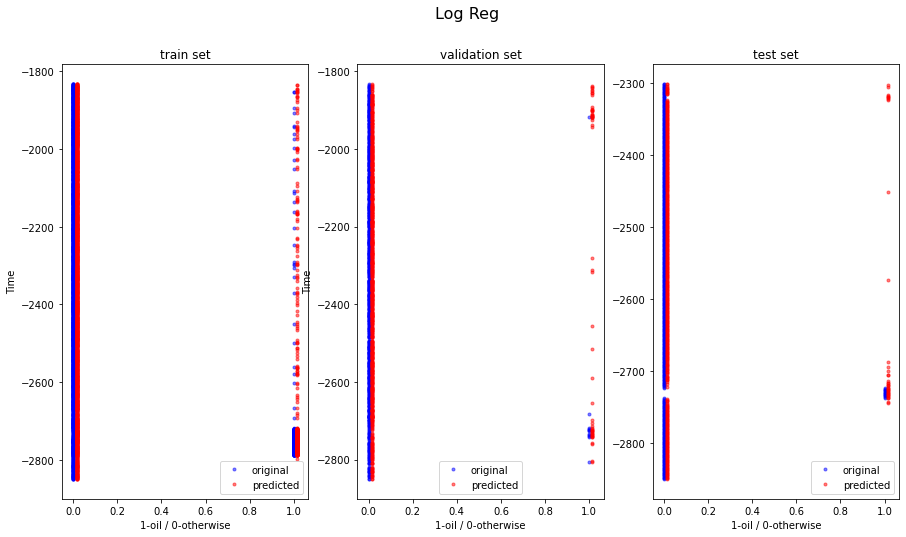

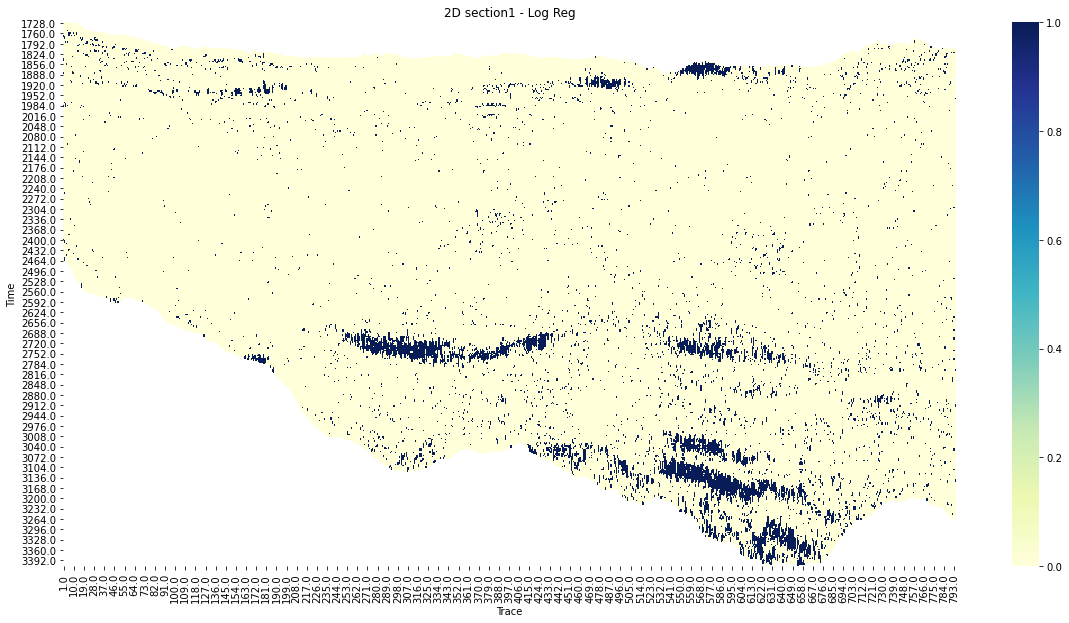

In [883]:
#y_train_pred, y_val_pred, y_test_pred = prec_recall_fscore_train_val_test(log_reg,X_train, y_train, X_val, y_val, X_test, y_test)

#plot_real_predicted(X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, 'Log Reg')
output_function(log_reg, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)

{'clf__C': 100, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Precision/Recall/ F-score on train set : 

Precision:  0.9955401387512388
Recall:  1.0
F-score:  0.9977650856717158

 Precision/ Recall/ F-score on validation set : 

Precision:  0.34615384615384615
Recall:  0.75
F-score:  0.4736842105263157

 Precision/ Recall/ F-score on test set : 

Precision:  0.6190476190476191
Recall:  0.9285714285714286
F-score:  0.742857142857143


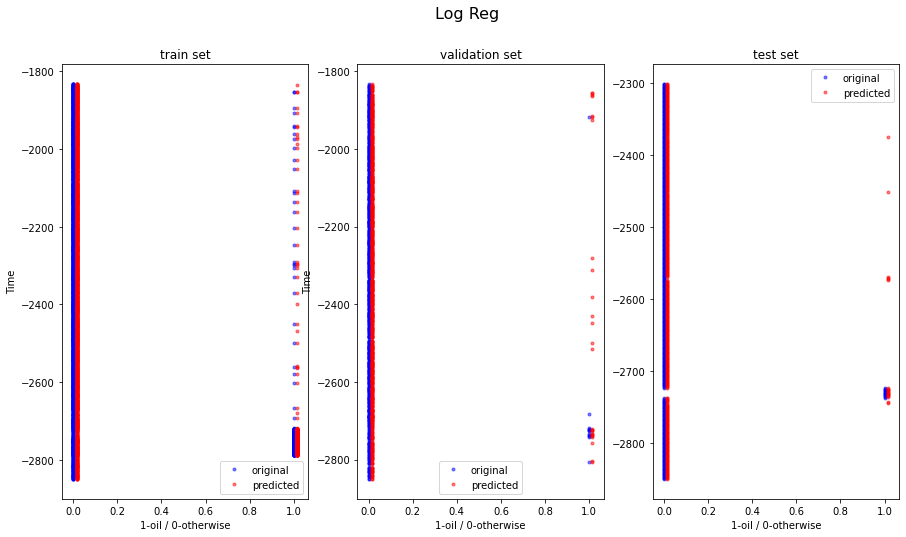

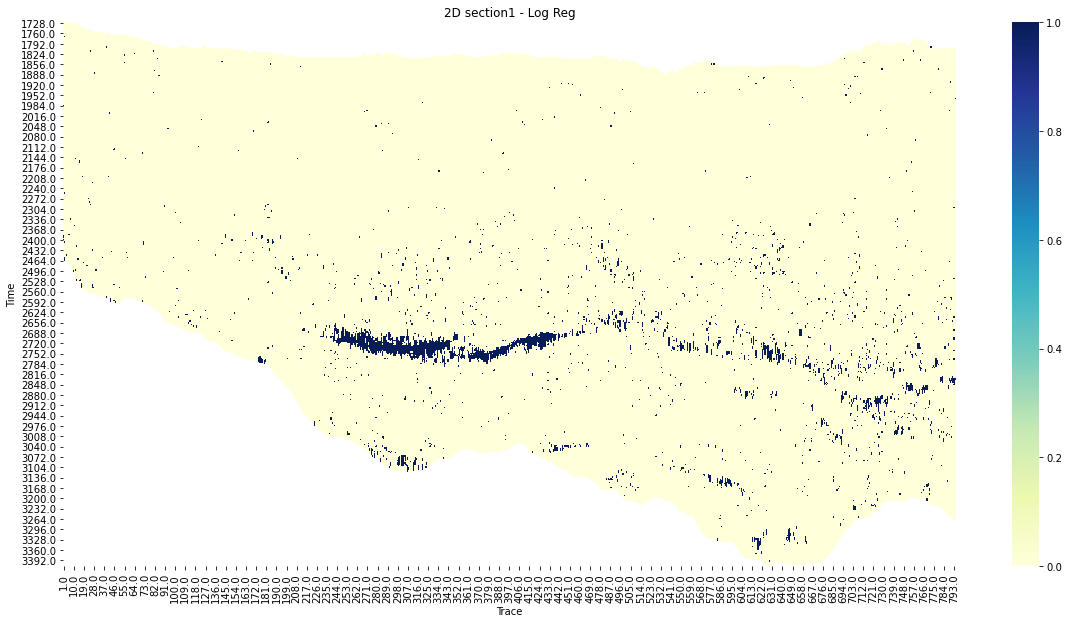

In [884]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(log_reg, log_reg_params, X_train, y_train)
    output_function(cv, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

Best Hyperparameters: {'clf__C': 100, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'} 

Mean test score: 0.9971090298097188 

Std test score: 0.001841964605245036 

Precision/Recall/ F-score on train set : 

Precision:  0.9955401387512388
Recall:  1.0
F-score:  0.9977650856717158

 Precision/ Recall/ F-score on validation set : 

Precision:  0.34615384615384615
Recall:  0.75
F-score:  0.4736842105263157

 Precision/ Recall/ F-score on test set : 

Precision:  0.6190476190476191
Recall:  0.9285714285714286
F-score:  0.742857142857143


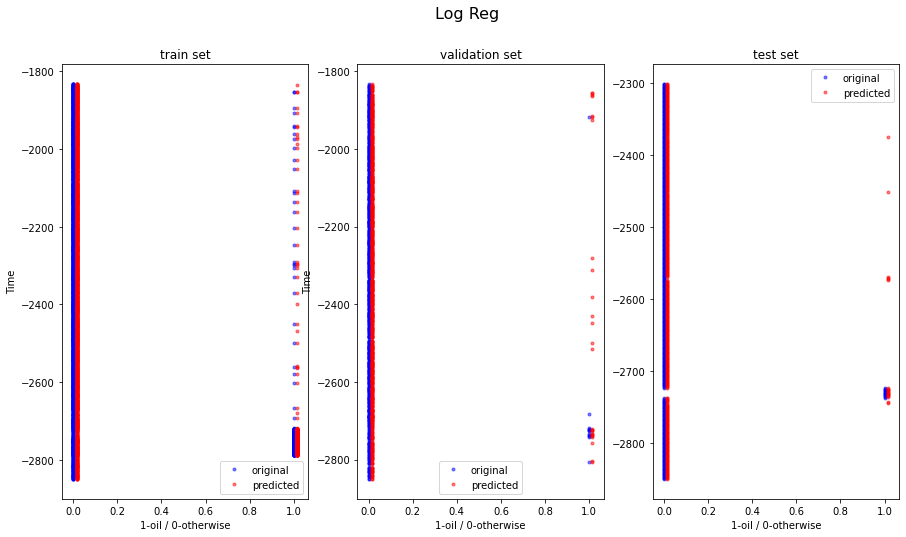

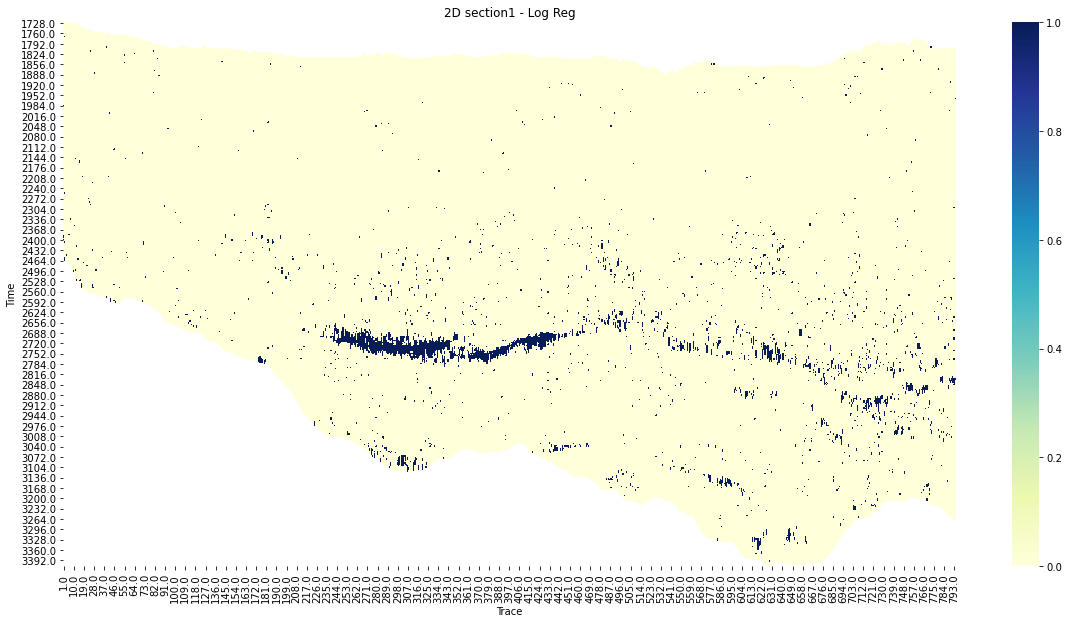

In [885]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(log_reg, log_reg_params,  X_train, y_train, K_folds)
    output_function(result, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

# Gaussian Naive Bayes


In [886]:
# Logistic Regression
gnb = Pipeline([
    ('prep', col_transform),
    ('clf', GaussianNB())
])

gnb.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Imp', 'Sweetness', 'AmpEnv', 'Seismic'], dtype='object'))])),
                ('clf', GaussianNB())])

Precision/Recall/ F-score on train set : 

Precision:  0.9546783625730995
Recall:  0.9751119960179193
F-score:  0.9647869982762867

 Precision/ Recall/ F-score on validation set : 

Precision:  0.21951219512195122
Recall:  0.75
F-score:  0.339622641509434

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


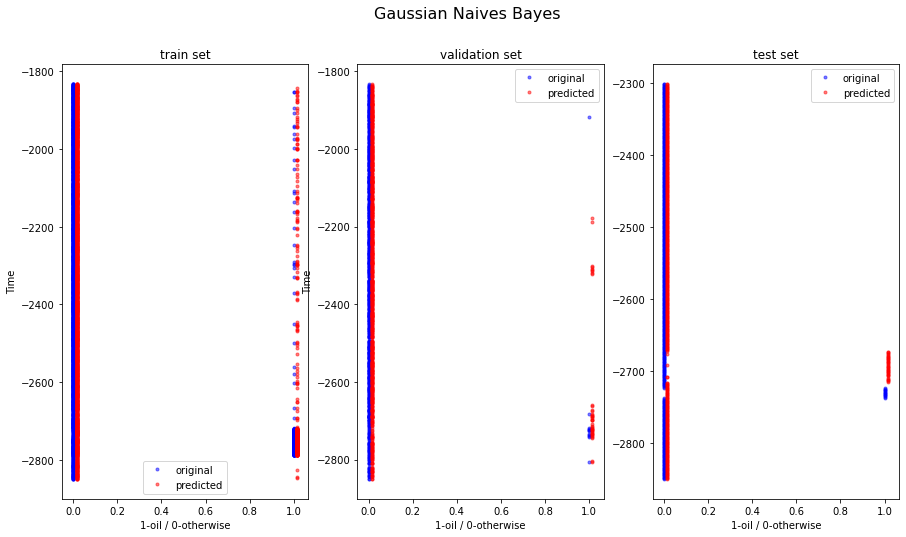

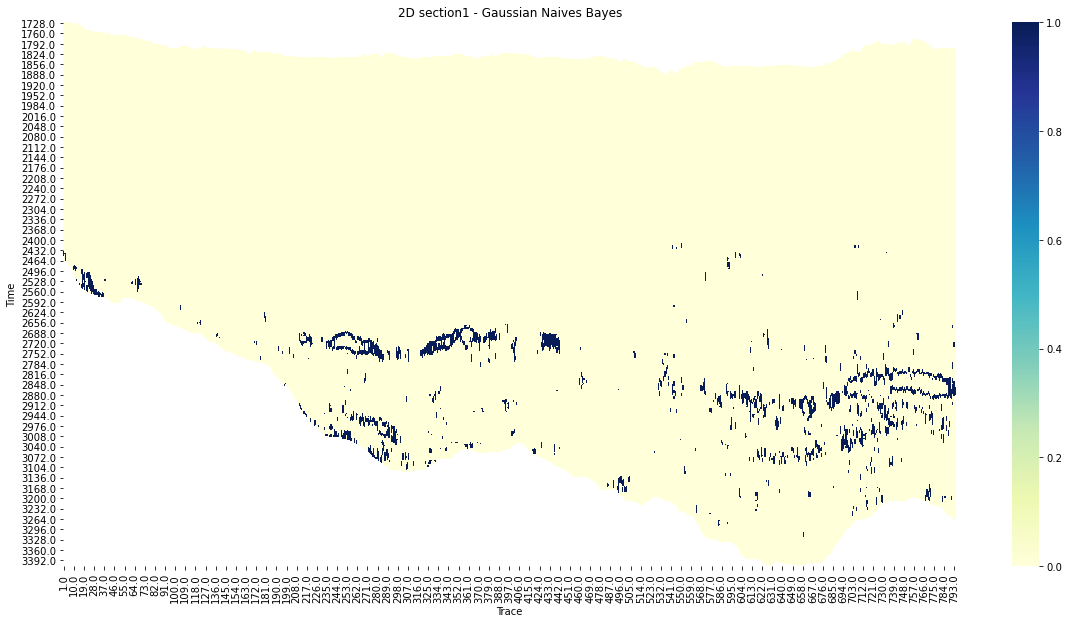

In [887]:
output_function(gnb, 'Gaussian Naives Bayes', X_train, y_train, X_val, y_val, X_test, y_test)

{'clf__var_smoothing': 1e-08}
Precision/Recall/ F-score on train set : 

Precision:  0.9546783625730995
Recall:  0.9751119960179193
F-score:  0.9647869982762867

 Precision/ Recall/ F-score on validation set : 

Precision:  0.21951219512195122
Recall:  0.75
F-score:  0.339622641509434

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


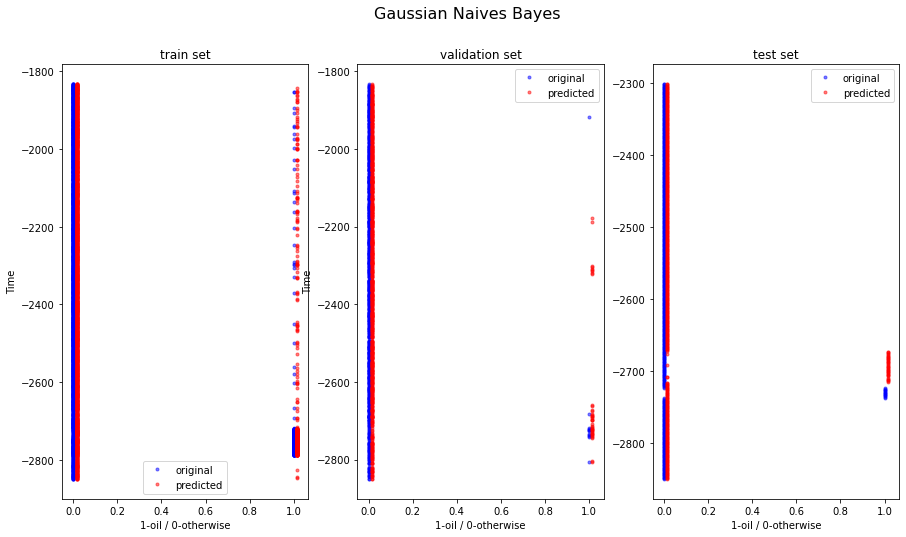

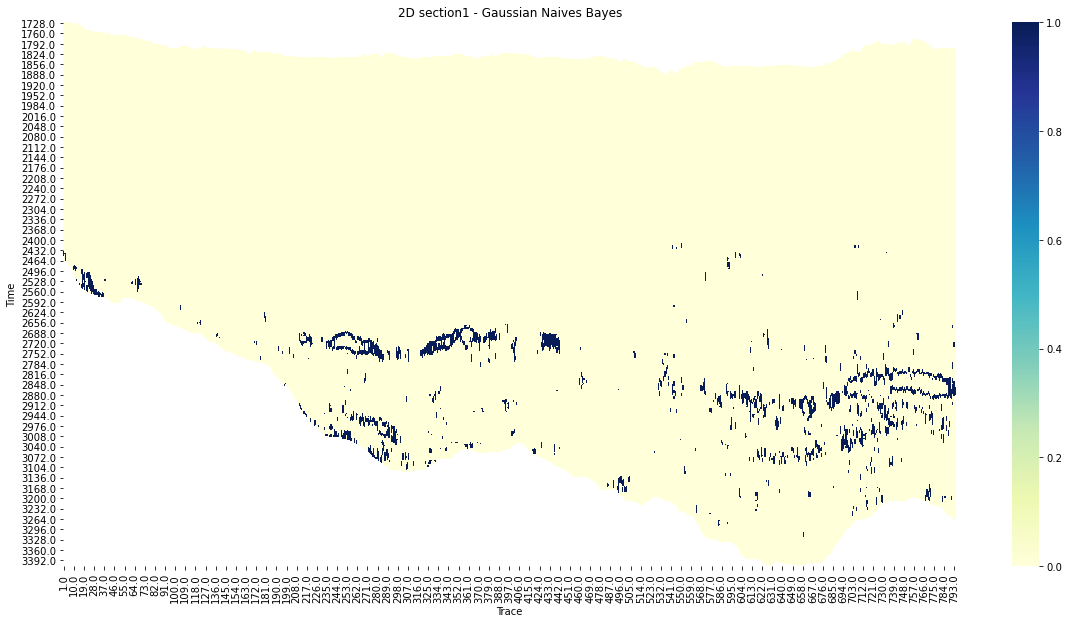

In [888]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(gnb, gnb_params, X_train, y_train)
    output_function(cv, 'Gaussian Naives Bayes', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'Gnb_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

Best Hyperparameters: {'clf__var_smoothing': 1e-08} 

Mean test score: 0.9648759622588831 

Std test score: 0.004746709469927264 

Precision/Recall/ F-score on train set : 

Precision:  0.9546783625730995
Recall:  0.9751119960179193
F-score:  0.9647869982762867

 Precision/ Recall/ F-score on validation set : 

Precision:  0.21951219512195122
Recall:  0.75
F-score:  0.339622641509434

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


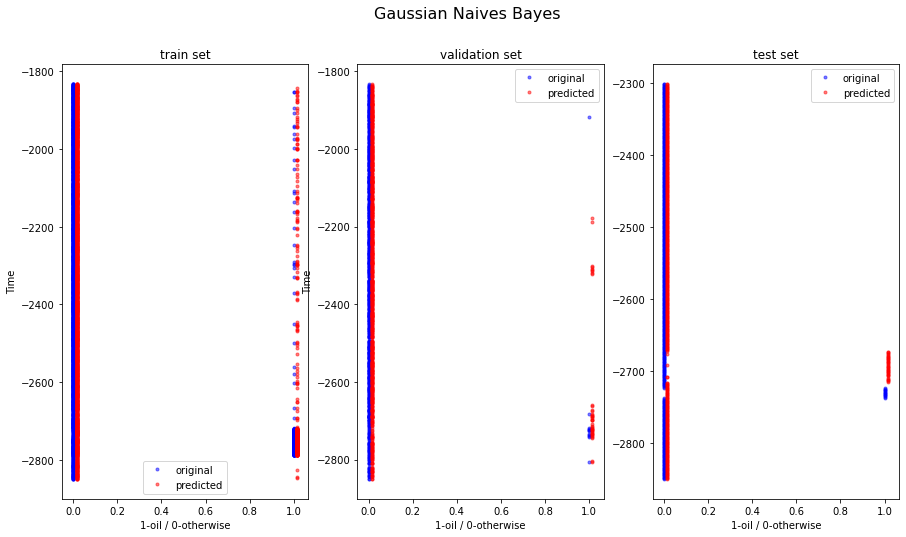

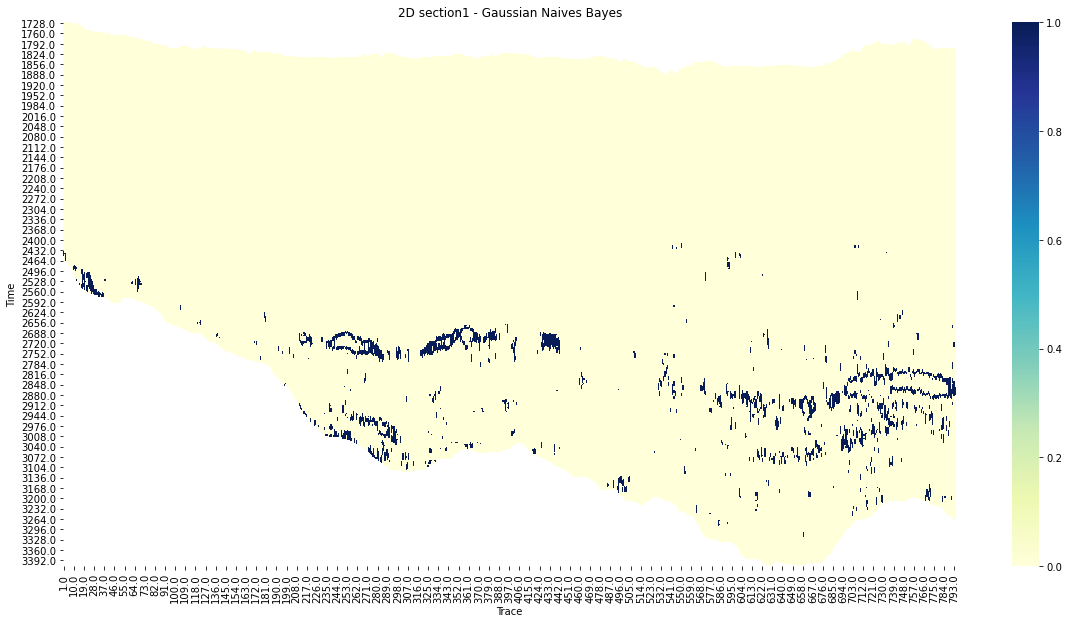

In [890]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(gnb, gnb_params, X_train, y_train, K_folds)
    output_function(result, 'Gaussian Naives Bayes',  X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'gnb_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

# Support Vector Machine

In [891]:
svm=Pipeline([
    ('prep',col_transform), 
    ('clf', SVC(kernel='poly', random_state=42))
    ])

svm.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Imp', 'Sweetness', 'AmpEnv', 'Seismic'], dtype='object'))])),
                ('clf', SVC(kernel='poly', random_state=42))])

Precision/Recall/ F-score on train set : 

Precision:  0.9106980961015413
Recall:  1.0
F-score:  0.9532621589561091

 Precision/ Recall/ F-score on validation set : 

Precision:  0.08695652173913043
Recall:  0.8333333333333334
F-score:  0.15748031496062992

 Precision/ Recall/ F-score on test set : 

Precision:  0.2
Recall:  1.0
F-score:  0.33333333333333337


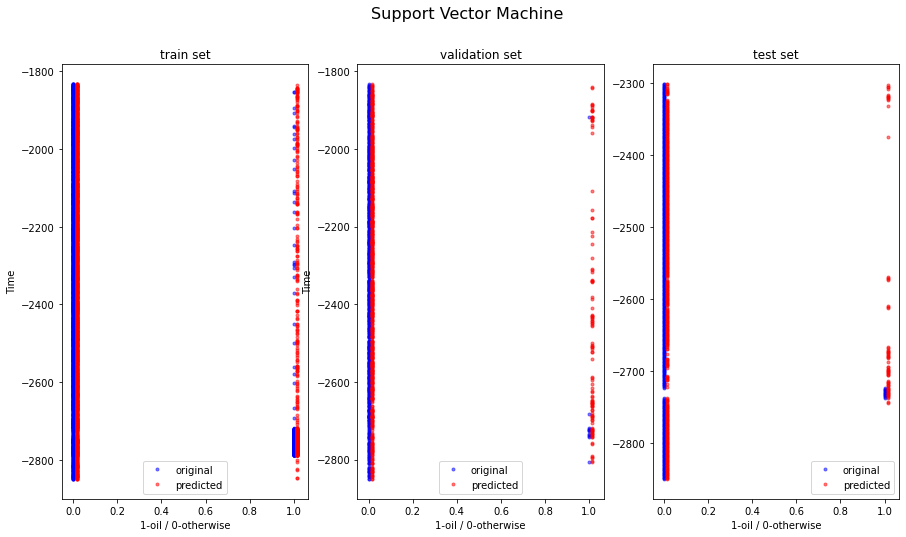

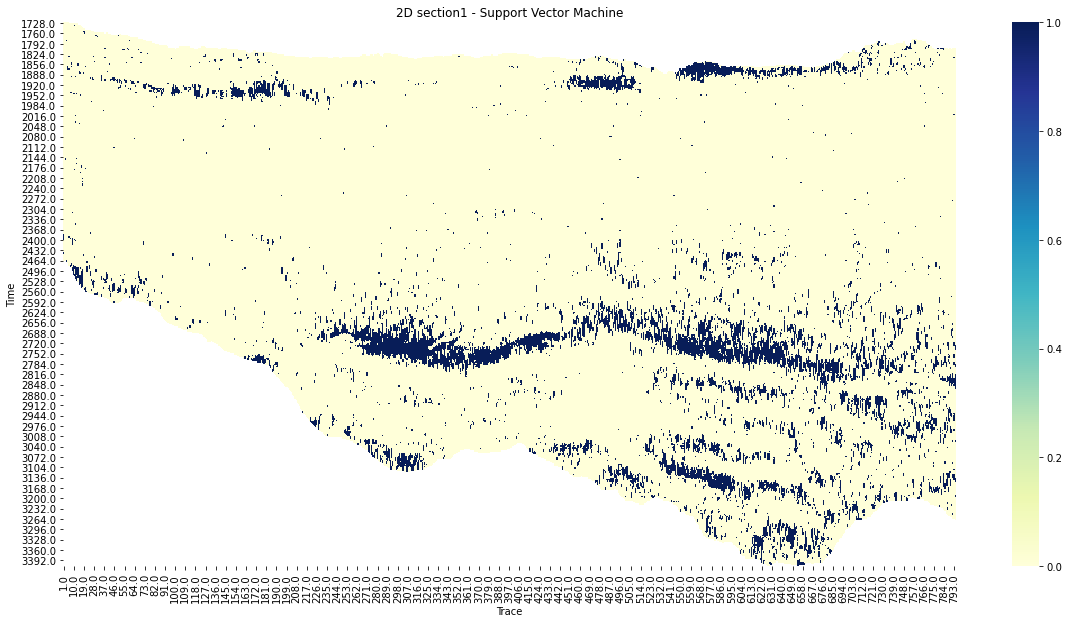

In [892]:
output_function(svm, 'Support Vector Machine', X_train, y_train, X_val, y_val, X_test, y_test)

{'clf__C': 50, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Precision/Recall/ F-score on train set : 

Precision:  0.9106980961015413
Recall:  1.0
F-score:  0.9532621589561091

 Precision/ Recall/ F-score on validation set : 

Precision:  0.08695652173913043
Recall:  0.8333333333333334
F-score:  0.15748031496062992

 Precision/ Recall/ F-score on test set : 

Precision:  0.2
Recall:  1.0
F-score:  0.33333333333333337


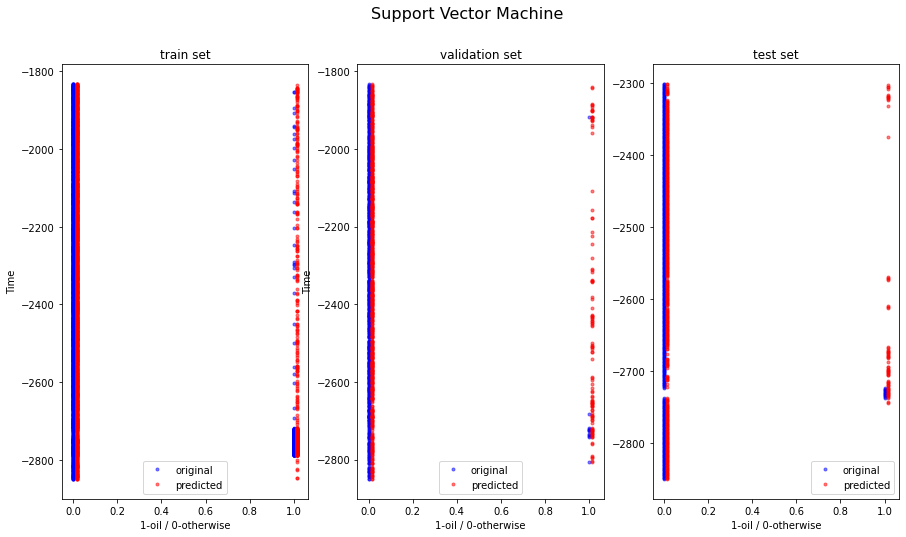

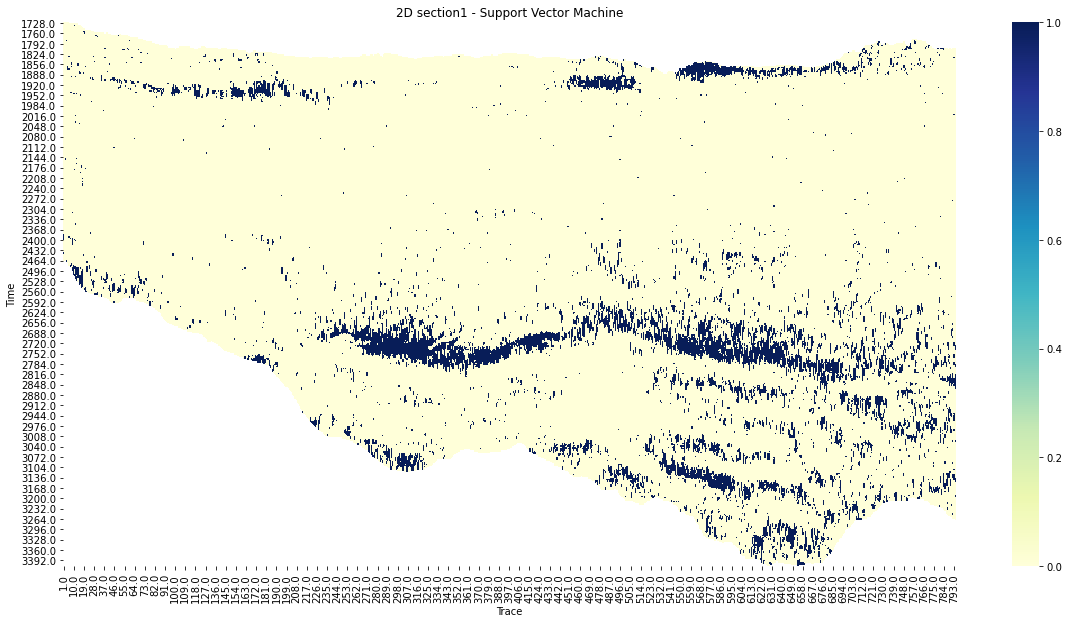

In [893]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(svm, svm_params, X_train, y_train)
    output_function(svm, 'Support Vector Machine', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'Svm_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

Best Hyperparameters: {'clf__C': 50, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'} 

Mean test score: 0.9999171842650103 

Std test score: 0.0003098681065651082 

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  0.6666666666666666
Recall:  0.6666666666666666
F-score:  0.6666666666666666

 Precision/ Recall/ F-score on test set : 

Precision:  0.9230769230769231
Recall:  0.8571428571428571
F-score:  0.888888888888889


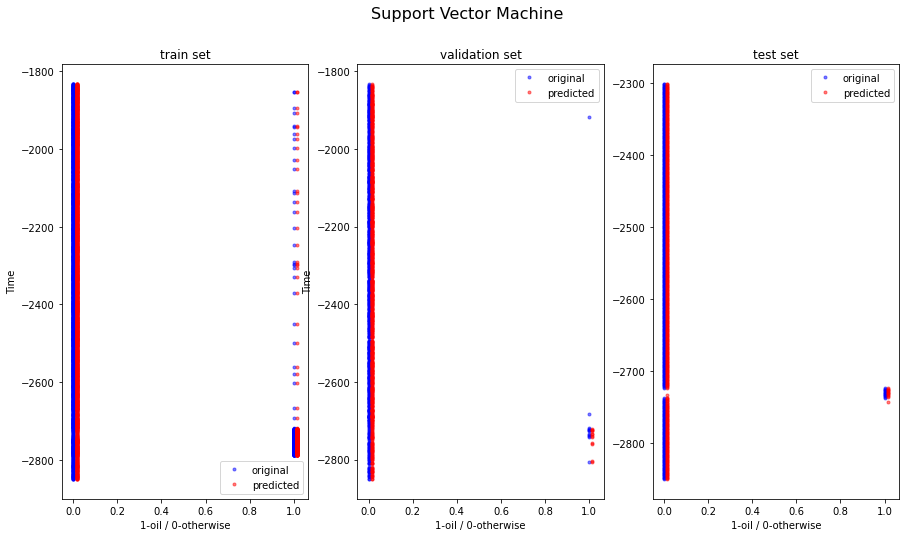

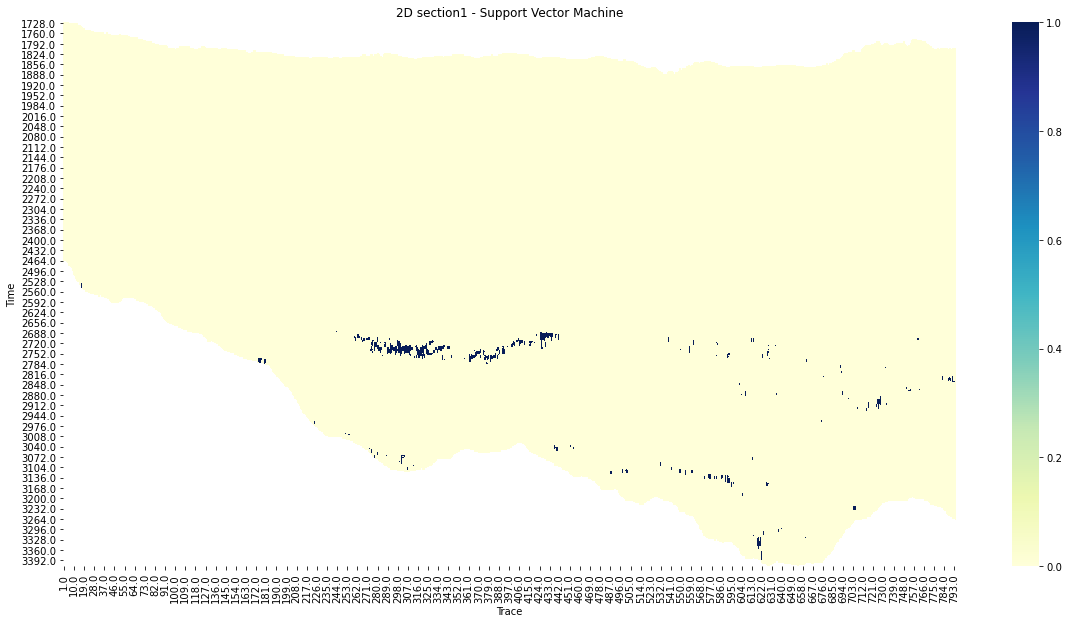

In [894]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(svm, svm_params, X_train, y_train, K_folds)
    output_function(result, 'Support Vector Machine', X_train, y_train, X_val, y_val,  X_test, y_test)
    
    # save model to the .pkl file
    filename = 'svm_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

# Gradient Boosting Classifier

In [62]:
gbc=Pipeline([
    ('prep',col_transform), 
    ('clf', GradientBoostingClassifier(random_state=42))
    ])

gbc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Imp', 'Sweetness', 'AmpEnv', 'Seismic'], dtype='object'))])),
                ('clf', GradientBoostingClassifier(random_state=42))])

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  0.47058823529411764
Recall:  0.6666666666666666
F-score:  0.5517241379310345

 Precision/ Recall/ F-score on test set : 

Precision:  0.8
Recall:  0.5714285714285714
F-score:  0.6666666666666666


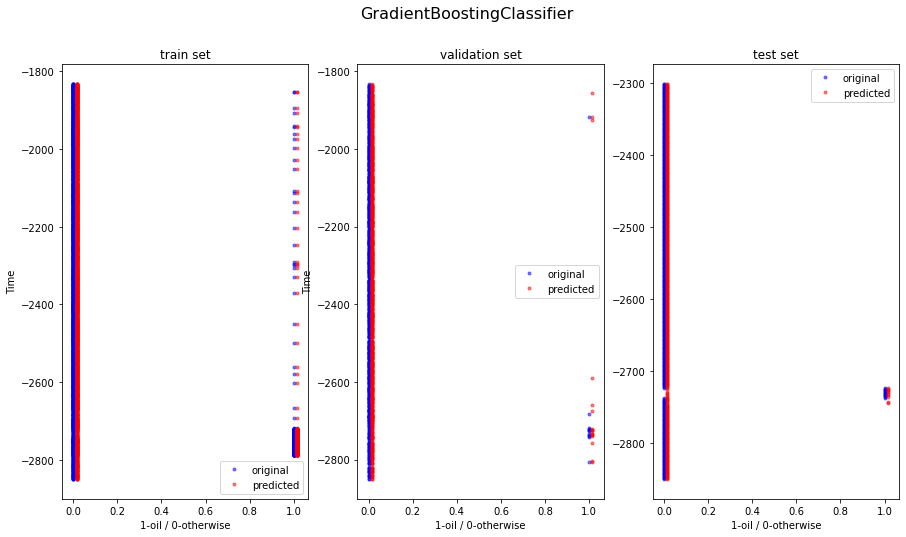

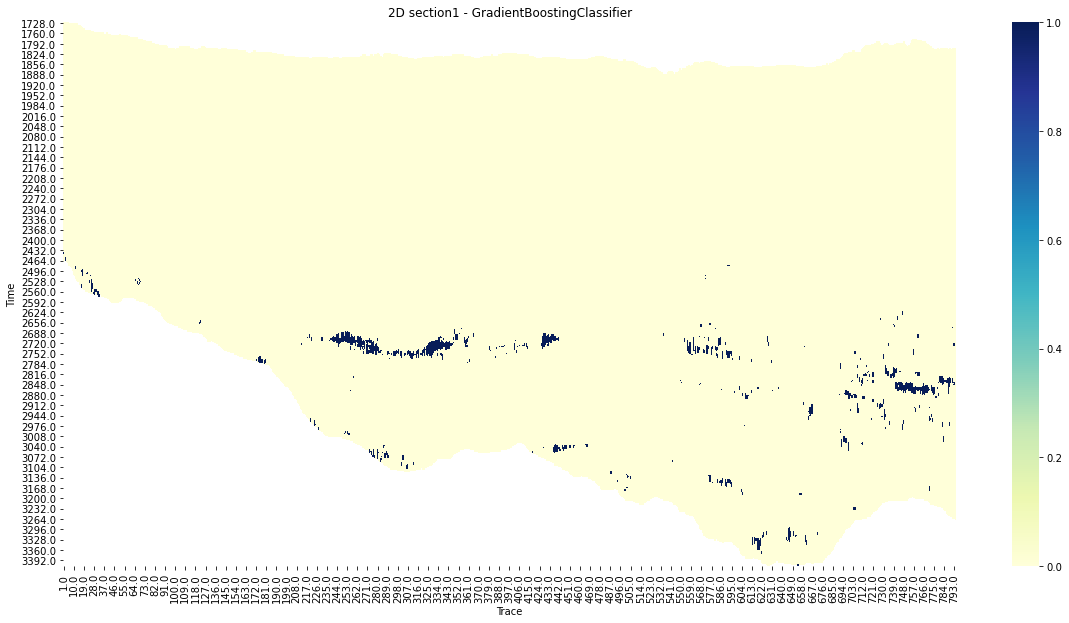

In [63]:
output_function(gbc, 'GradientBoostingClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(gbc, gbc_params, X_train, y_train)
    output_function(svm, 'GradientBoostingClassifier', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'gbc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

In [ ]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(gbc, gbc_params, X_train, y_train, K_folds)
    output_function(result, 'GradientBoostingClassifier', X_train, y_train, X_val, y_val,  X_test, y_test)
    
    # save model to the .pkl file
    filename = 'gbc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## MLPClassifier (NN)

In [62]:
'''mlpc= Pipeline([
    ('prep',col_transform), 
    ('clf', MLPClassifier(solver='lbfgs', alpha=1e-5,
                          hidden_layer_sizes=(5,5,2), random_state=42))
     ])
'''
mlpc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Imp', 'Sweetness', 'AmpEnv', 'Seismic'], dtype='object'))])),
                ('clf', MLPClassifier())])

Precision/Recall/ F-score on train set : 

Precision:  0.9995024875621891
Recall:  1.0
F-score:  0.9997511818860414

 Precision/ Recall/ F-score on validation set : 

Precision:  0.5263157894736842
Recall:  0.8333333333333334
F-score:  0.6451612903225806

 Precision/ Recall/ F-score on test set : 

Precision:  0.9230769230769231
Recall:  0.8571428571428571
F-score:  0.888888888888889


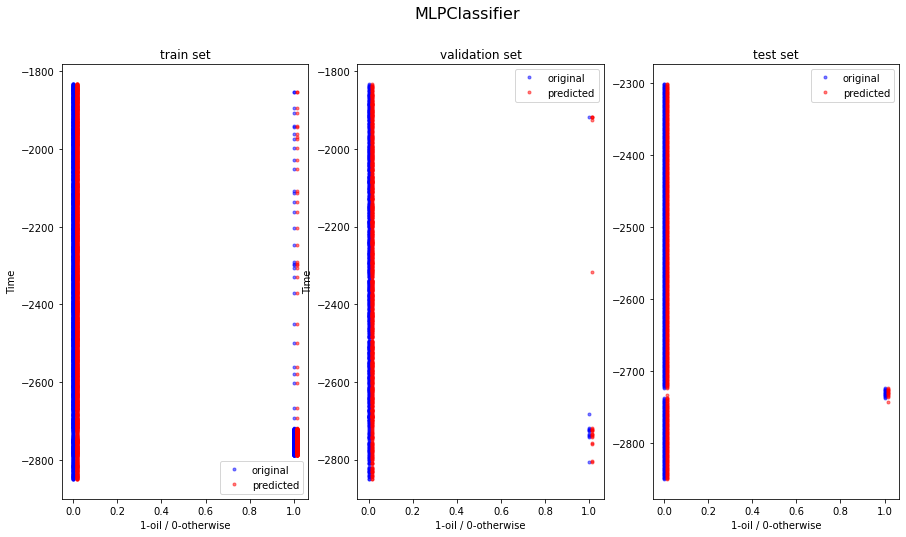

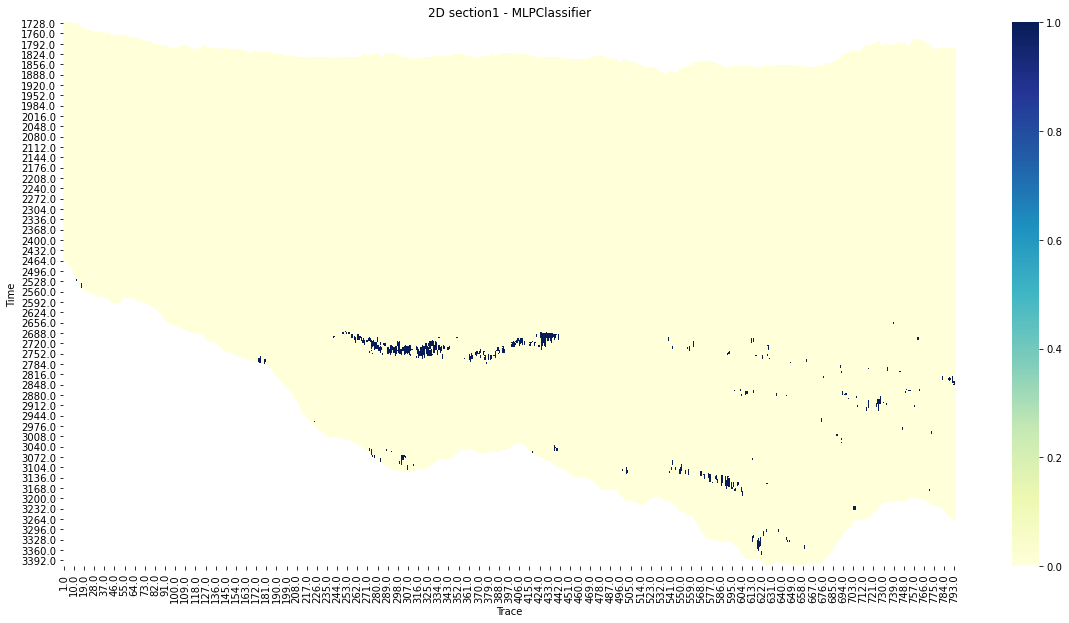

In [63]:
output_function(mlpc, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(mlpc, mlpc_params, X_train, y_train)
    output_function(mlpc, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'mlpc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

In [ ]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(mlpc, mlpc_params,X_train, y_train, K_folds)
    output_function(result, 'MLPClassifier',  X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'mlpc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))